# Chili hotness prediction on Scoville scale

Kaggle username: Hongpeng Zhang

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

### Reading data

In [2]:
df = pd.read_csv('../CA5/data/train.csv', sep=',', index_col=0)

In [3]:
df_test = pd.read_csv('../CA5/data/test.csv', sep=',', index_col=0)

In [4]:
df.head()

Capsaicin level  Pungent odor  Vitamin C  Water  Light transmittance  \
0            166.7           6.8        0.0  77.95                 32.4   
1            170.4           5.7        0.0  74.06                 39.0   
2            212.5           3.1        0.0  88.27                 22.4   
3            216.0           1.0        0.0  80.01                 22.4   
4            146.5           1.3      141.0  78.64                 28.8   

   Temp storage  Time storage  Dihydrocapsaicin level  Fibre density  \
0           7.5           4.0                    32.4          13.56   
1           4.7          52.0                    47.1           8.58   
2           5.9           1.0                   161.7          13.57   
3           6.4          31.0                    10.2          21.27   
4           4.6          38.0                    20.7           5.83   

   Protein density  Saturated fatty acids  Monounsaturated fatty acids  \
0             1.05                  24.47                         0.67   
1             0.93                  22.42                         1.10   
2             1.02                  22.15                         4.08   
3             0.98                  19.82                         0.57   
4             0.96                  23.95                         0.54   

   Polyunsaturated fatty acids  Scoville score  
0                         0.41       4051080.0  
1                         0.22       4258252.0  
2                         0.50       2678566.0  
3                         0.04        801070.0  
4                         0.32       2680508.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618 entries, 0 to 617
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Capsaicin level              618 non-null    float64
 1   Pungent odor                 618 non-null    float64
 2   Vitamin C                    618 non-null    float64
 3   Water                        618 non-null    float64
 4   Light transmittance          618 non-null    float64
 5   Temp storage                 618 non-null    float64
 6   Time storage                 618 non-null    float64
 7   Dihydrocapsaicin level       618 non-null    float64
 8   Fibre density                618 non-null    float64
 9   Protein density              618 non-null    float64
 10  Saturated fatty acids        618 non-null    float64
 11  Monounsaturated fatty acids  618 non-null    float64
 12  Polyunsaturated fatty acids  618 non-null    float64
 13  Scoville score      

### Data exploration and visualisation

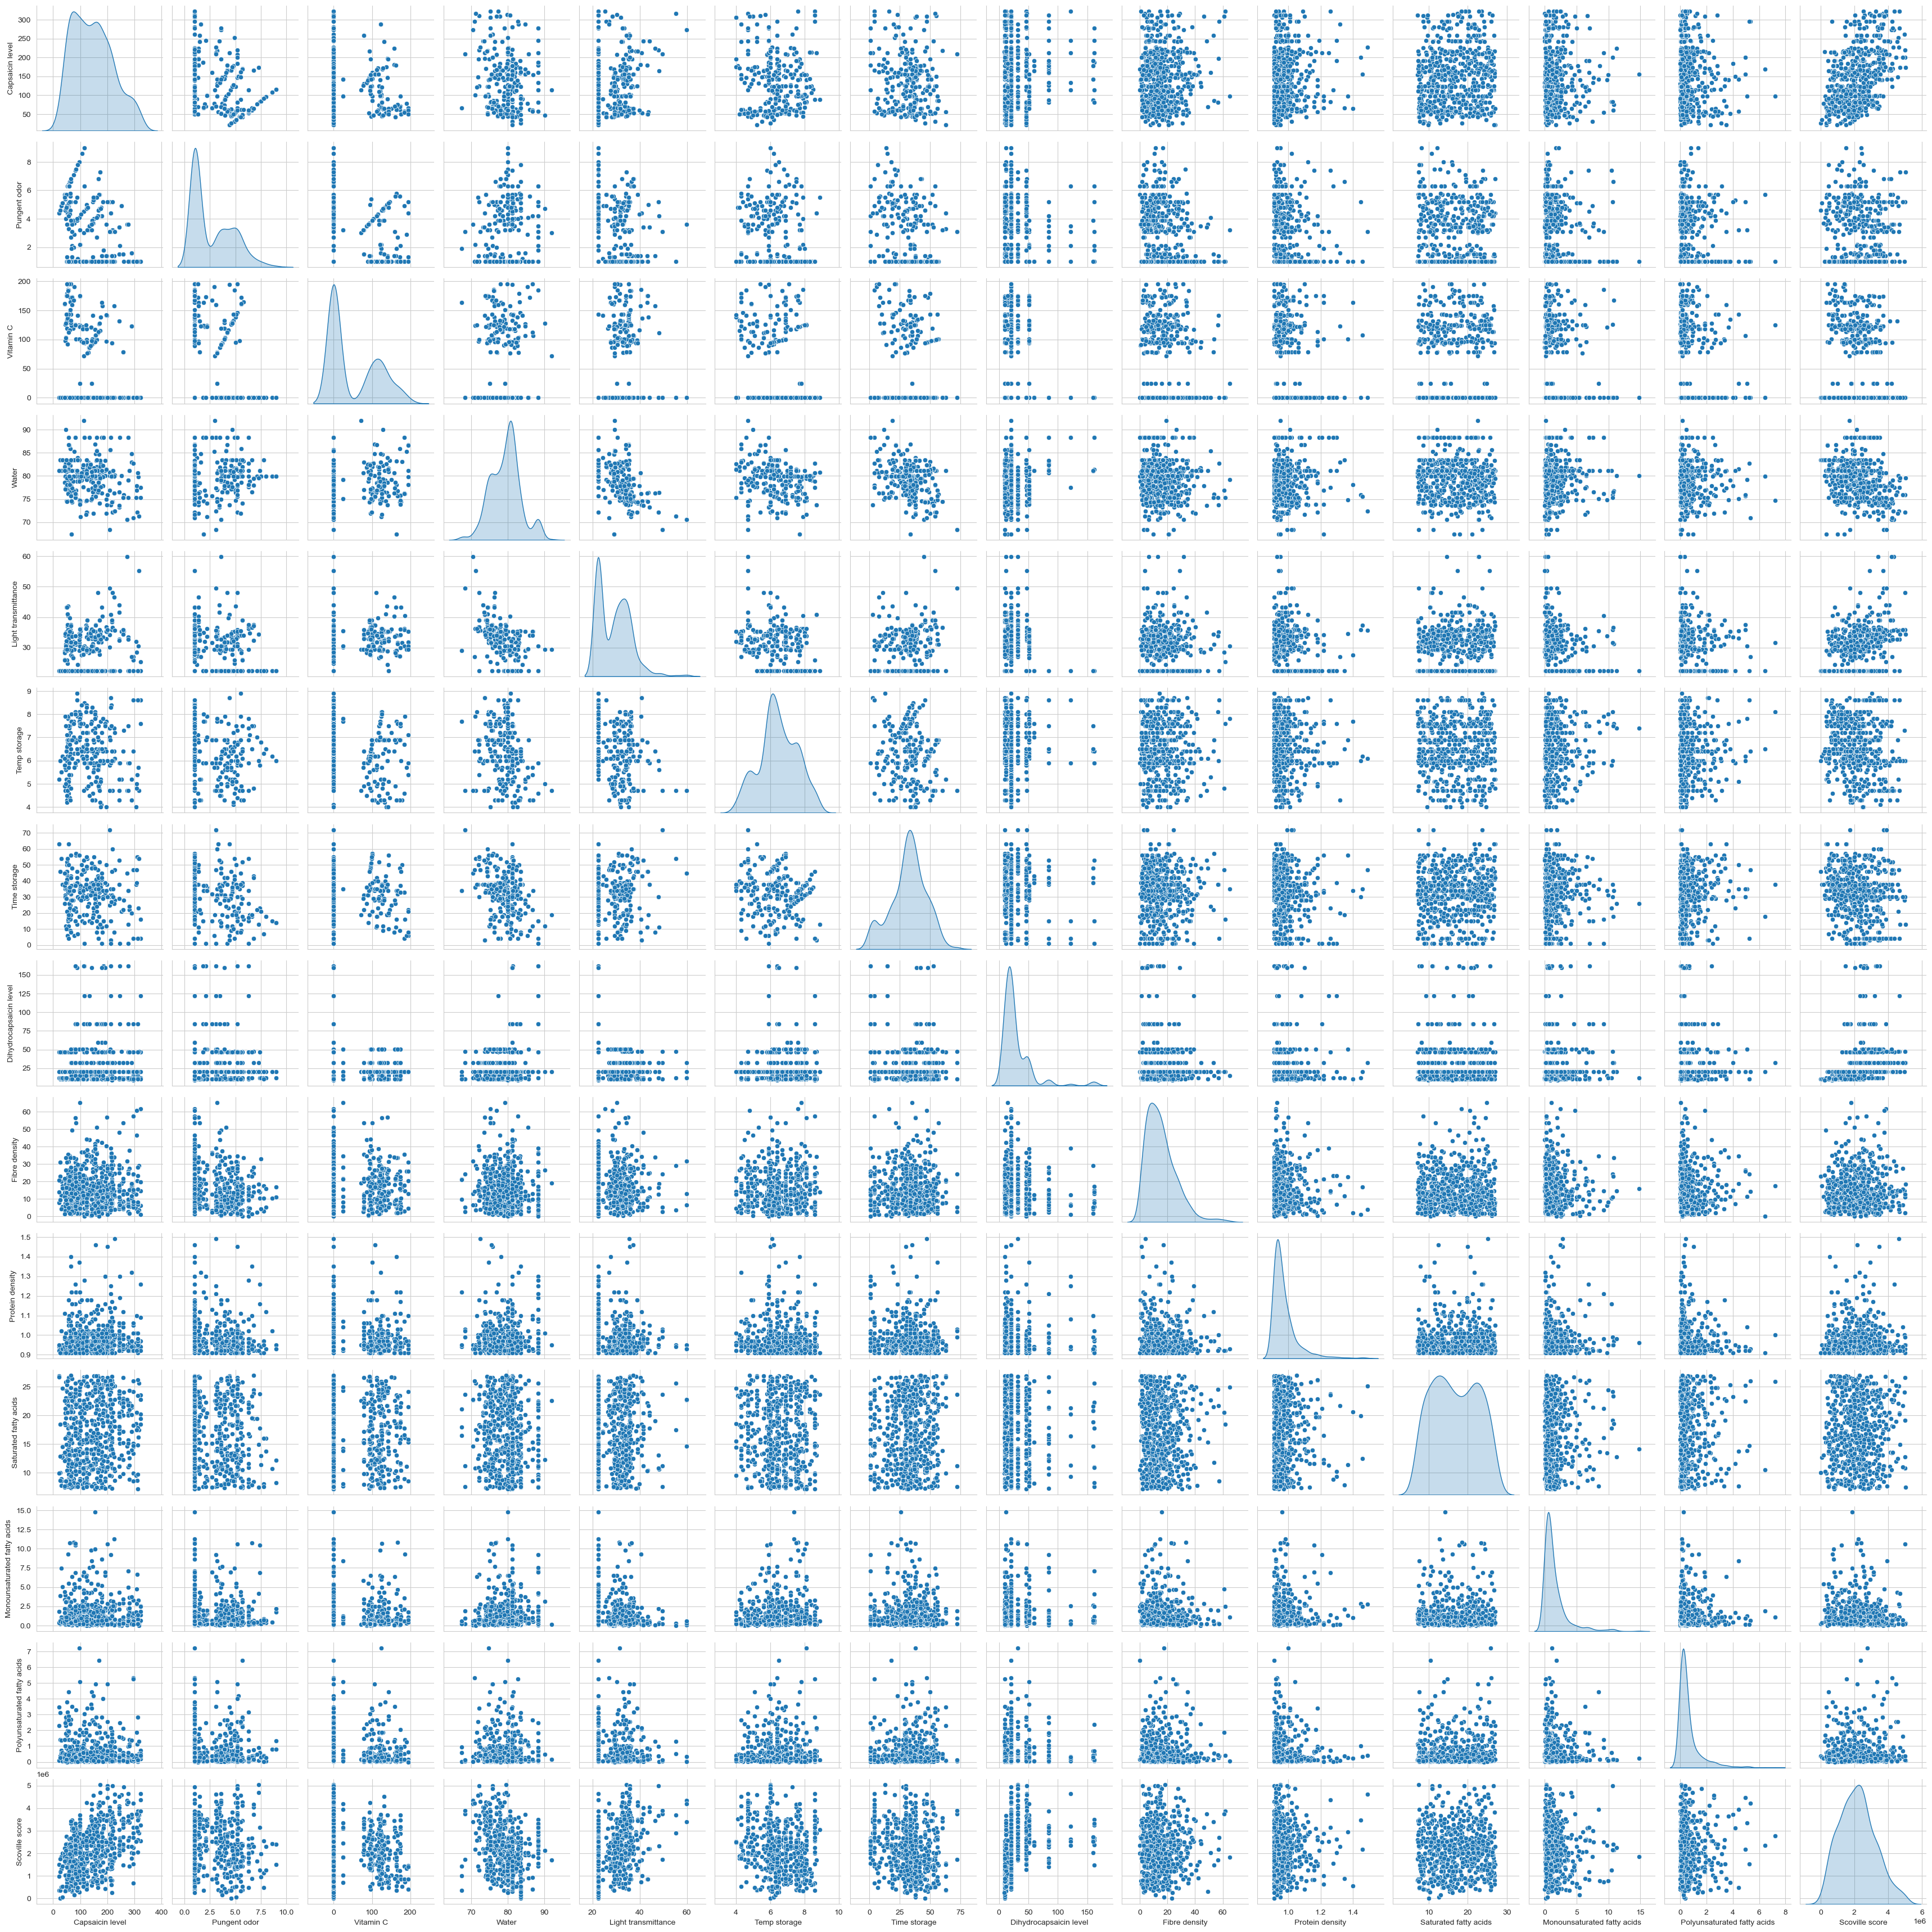

In [6]:
sns.pairplot(df, diag_kind='kde')

From the pair plot, we can see the distribution of several features, such as "Polyunsaturated fatty acids", "Fibre density", "Protein density", "Monounsaturated fatty acids", are quite strange, maybe there are too many outliers in these features.

<Axes: >

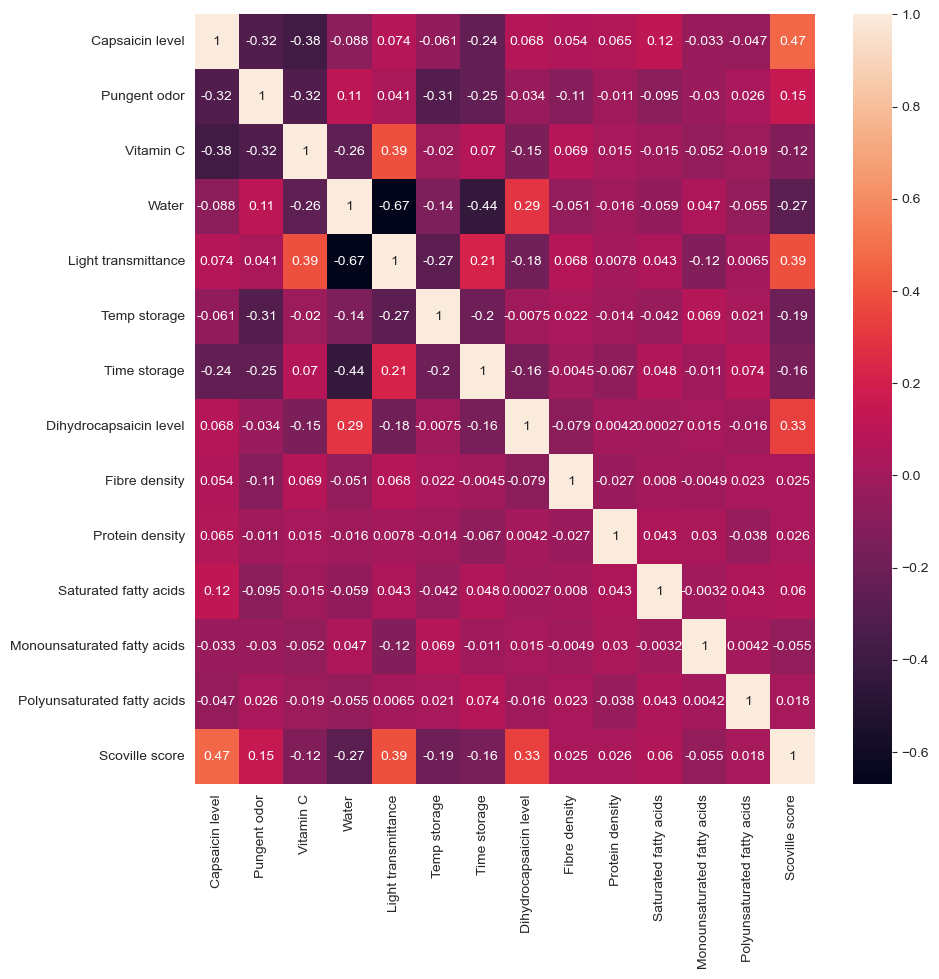

In [7]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [8]:
df.corr()['Scoville score'].abs().sort_values()

Polyunsaturated fatty acids    0.018166
Fibre density                  0.024972
Protein density                0.026316
Monounsaturated fatty acids    0.055012
Saturated fatty acids          0.060038
Vitamin C                      0.122567
Pungent odor                   0.151757
Time storage                   0.161018
Temp storage                   0.194760
Water                          0.273227
Dihydrocapsaicin level         0.332359
Light transmittance            0.386937
Capsaicin level                0.470390
Scoville score                 1.000000
Name: Scoville score, dtype: float64

"Polyunsaturated fatty acids", "Fibre density", "Protein density", "Monounsaturated fatty acids", these features are the least correlated features with Scoville score, since they have strange distributions, so maybe it's better to just delete these 4 features.

### Data cleaning

Delete the 4 features.

In [9]:
df_del = df.drop(columns=["Polyunsaturated fatty acids", "Fibre density", "Protein density", "Monounsaturated fatty acids"])

In [10]:
df_del.head()

Capsaicin level  Pungent odor  Vitamin C  Water  Light transmittance  \
0            166.7           6.8        0.0  77.95                 32.4   
1            170.4           5.7        0.0  74.06                 39.0   
2            212.5           3.1        0.0  88.27                 22.4   
3            216.0           1.0        0.0  80.01                 22.4   
4            146.5           1.3      141.0  78.64                 28.8   

   Temp storage  Time storage  Dihydrocapsaicin level  Saturated fatty acids  \
0           7.5           4.0                    32.4                  24.47   
1           4.7          52.0                    47.1                  22.42   
2           5.9           1.0                   161.7                  22.15   
3           6.4          31.0                    10.2                  19.82   
4           4.6          38.0                    20.7                  23.95   

   Scoville score  
0       4051080.0  
1       4258252.0  
2       2678566.0  
3        801070.0  
4       2680508.0

### Data exploration after cleaning

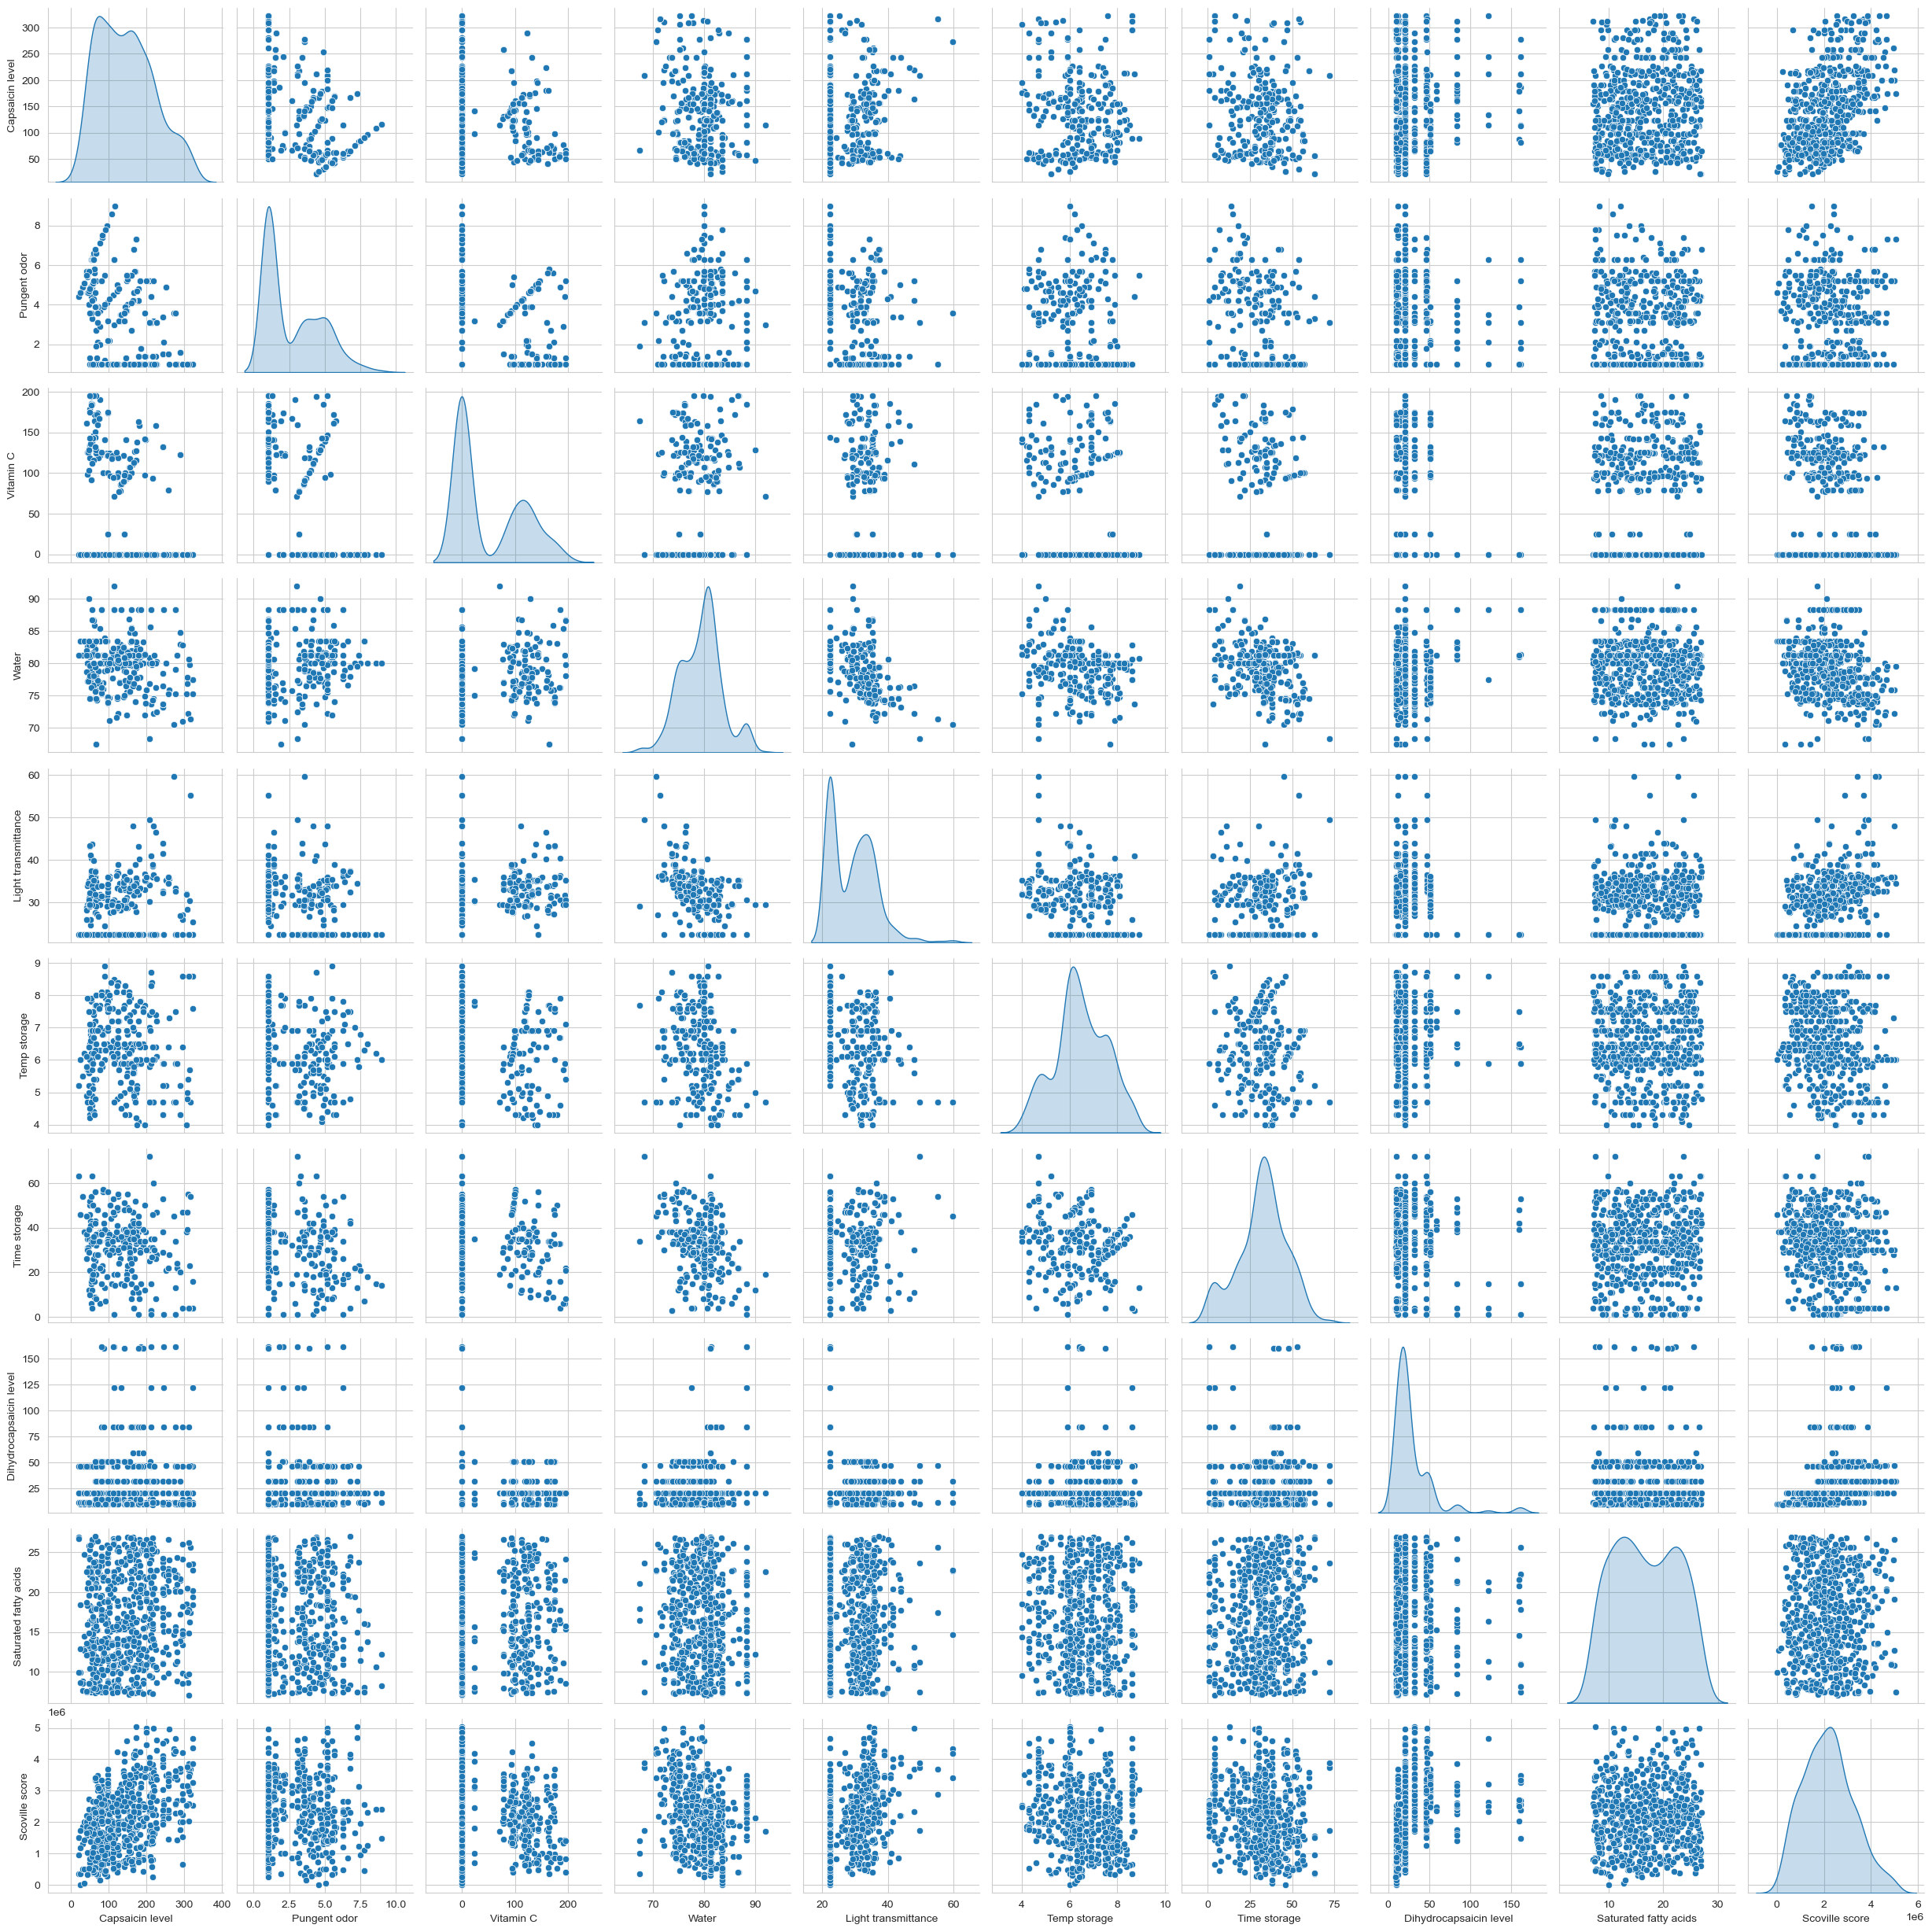

In [11]:
sns.pairplot(df_del, diag_kind='kde')

<Axes: >

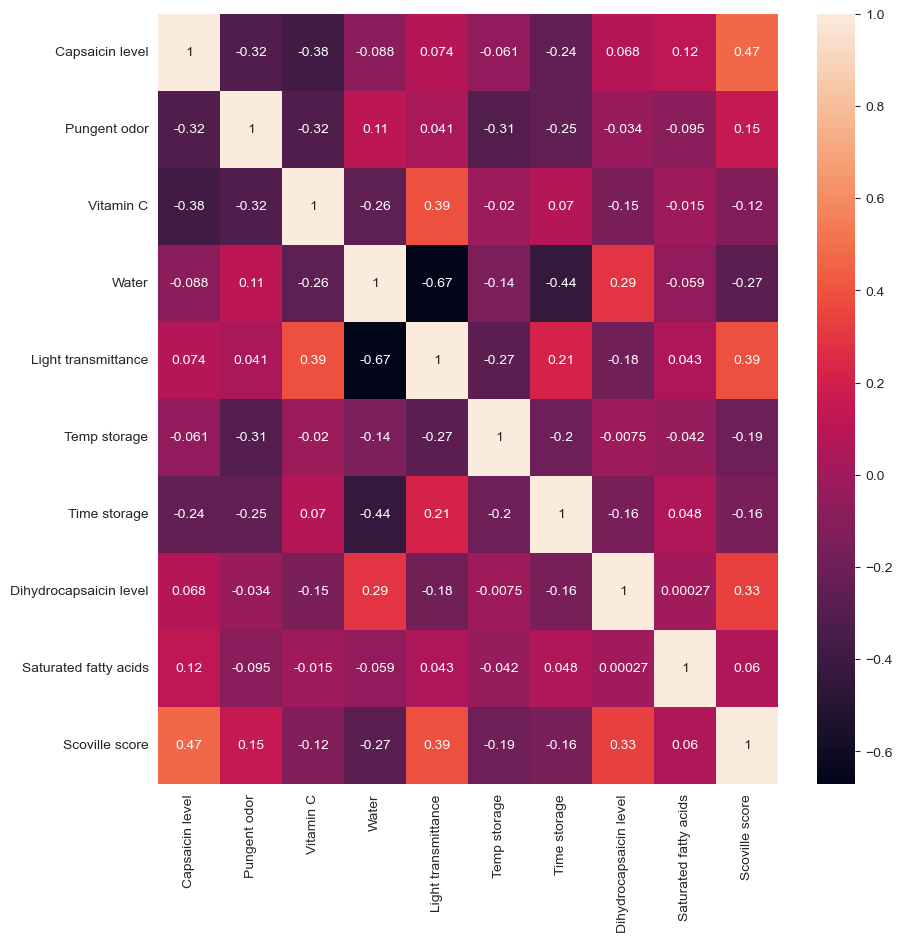

In [12]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(df_del.corr(), annot=True)

### Data preprocessing

#### Train test split

In [13]:
X = df_del.loc[:,:'Saturated fatty acids'].values
y = df_del.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Scaling

In [14]:
miu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0, ddof=1)
X_train_sc = (X_train - miu) / sigma
X_test_sc = (X_test - miu) / sigma

#### PCA

In [15]:
pca = PCA(n_components=9)
pca.fit(X_train_sc)
pca.explained_variance_ratio_.cumsum()

array([0.25983345, 0.43145554, 0.58113175, 0.69472727, 0.80017896,
       0.89652092, 0.977841  , 0.99676663, 1.        ])

We can see the cummulated explained variance reached 0.99 until the 8th feature, only 1 feature less than 9 features we have in total, so PCA doesn't work well in this case.

### Modelling

#### Data pipeline with regression model

Adaboost using decision tree

In [16]:
tree = DecisionTreeRegressor(criterion    = 'absolute_error',
                              random_state = 1)
ada = AdaBoostRegressor(n_estimators = 500,
                        estimator = tree,
                         random_state=1)

In [17]:
param_range  = [0.01, 0.1, 1.0, 10.0]   # For different learning rates in adaboost.
param_range_loss = ['linear', 'square', 'exponential']      # For different loss functions.
param_grid_ada   = [{ 'learning_rate': param_range,
                      'loss': param_range_loss}]

In [18]:
# Use grid search to get the best hyperparameters for adaboost
gs_ada = GridSearchCV(estimator=ada,
                  param_grid=param_grid_ada,
                  scoring='neg_mean_absolute_error',
                  cv=10,
                  n_jobs=-1)
error_ada = cross_val_score(gs_ada, X_train_sc, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [19]:
error_ada

array([-280159.50505051, -270062.55555556, -323987.33333333,
       -268179.07070707, -282668.15306122])

In [20]:
gs_ada.fit(X_train_sc, y_train)

GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                                         random_state=1),
                                         n_estimators=500, random_state=1),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.01, 0.1, 1.0, 10.0],
                          'loss': ['linear', 'square', 'exponential']}],
             scoring='neg_mean_absolute_error')

In [21]:
gs_ada.best_params_

{'learning_rate': 1.0, 'loss': 'square'}

In [22]:
gs_ada.best_score_

-266228.5646530612

In [23]:
gs_ada_best = gs_ada.best_estimator_

In [24]:
# The absolute error score for adaboost on the test set.
mean_absolute_error(y_test, gs_ada_best.predict(X_test_sc))

278502.23387096776

#### Data pipeline with classification model

##### Binning train target values

Can be performed with ex. pandas.qcut or pandas.cut

```python
n_bins = 10
y_train_binned = pd.cut(y_train, n_bins, labels=False) # or
y_train_binned = pd.qcut(y_train, n_bins, labels=False) 
```

In [25]:
n_bins = 10
y_label = pd.qcut(y, n_bins, labels=False)
# add the categorical label to the dataset
df_del['y_label'] = y_label

In [26]:
# Splite the new dateset
X = df_del.loc[:,:'Saturated fatty acids'].values
y_clf = df_del.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=1)

Use random forests classifier as ensemble classificaiton model.

In [27]:
# Make a pipline
RF = RandomForestClassifier()
pipe_RF = make_pipeline(StandardScaler(),
                        RF)

In [28]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [29]:
pipe_RF.score(X_test, y_test)

0.46774193548387094

In order to test the number of bins affects the performance of the model, we define a function which takes the number of bins as argument, and return the predict score.

In [30]:
def bin_score(n=10, df=df_del):
    y_label = pd.qcut(y, n, labels=False)
    # add the categorical label to the dataset
    df['y_label'] = y_label
    # Splite the new dateset
    X = df.iloc[:,:-2].values
    y_clf = df.iloc[:,-1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=1)
    # Make a pipline
    RF = RandomForestClassifier()
    pipe_RF = make_pipeline(StandardScaler(),
                            RF)
    pipe_RF.fit(X_train, y_train)

    return pipe_RF.score(X_test, y_test)

In [31]:
# Print the scores of different bins
for n in range(2,11):
    score = bin_score(n)
    print(f'bin : {n}, score: {score}')

bin : 2, score: 0.8548387096774194
bin : 3, score: 0.7903225806451613
bin : 4, score: 0.6774193548387096
bin : 5, score: 0.6854838709677419
bin : 6, score: 0.5806451612903226
bin : 7, score: 0.5483870967741935
bin : 8, score: 0.4838709677419355
bin : 9, score: 0.46774193548387094
bin : 10, score: 0.4596774193548387


Apparently, the model performs better when there are less bins than more bins.

#### Other models used for Kaggle submission

In [32]:
gbr = GradientBoostingRegressor(loss='absolute_error', random_state=1)

In [33]:
param_range  = [0.01, 0.1, 1.0, 10.0]   # For different learning rates in adaboost.
param_range_maxdepth = np.arange(1,10)  # For different max depth
param_grid_gbr = [{'learning_rate': param_range,
                   'max_depth': param_range_maxdepth}]

In [34]:
gs_gbr = GridSearchCV(estimator=gbr,
                  param_grid=param_grid_gbr,
                  scoring='neg_mean_absolute_error',
                  cv=10,
                  n_jobs=-1)
error_gbr = cross_val_score(gs_gbr, X_train_sc, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [35]:
error_gbr

array([-0.89290678, -0.91298831, -0.90866672, -0.7336554 , -0.83954686])

In [36]:
gs_gbr.fit(X_train_sc, y_train)

GridSearchCV(cv=10,
             estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 random_state=1),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.01, 0.1, 1.0, 10.0],
                          'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}],
             scoring='neg_mean_absolute_error')

In [37]:
gs_gbr.best_params_

{'learning_rate': 0.1, 'max_depth': 7}

In [38]:
gs_gbr.best_score_

-0.7858992376708231

### Final Evaluation

From grid search, we get the best hyperparameters for adaboost and gradientboost, in order to make the model perform better, we can also increase n_estimator larger. Here we set n_estimator to 1000, as a balance point between accuracy and computation time.

In [39]:
ada_1000 = AdaBoostRegressor(n_estimators = 1000,
                             estimator = tree,
                             learning_rate=0.1,
                             loss='square',
                             random_state=1)

In [40]:
ada_1000.fit(X, y)

AdaBoostRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                  random_state=1),
                  learning_rate=0.1, loss='square', n_estimators=1000,
                  random_state=1)

In [41]:
gbr_1000 = GradientBoostingRegressor(n_estimators = 1000,
                                     learning_rate=0.1,
                                     random_state=1,
                                     max_depth=6)

In [42]:
gbr_1000.fit(X, y)

GradientBoostingRegressor(max_depth=6, n_estimators=1000, random_state=1)

In [43]:
# Load the test data, and delete 4 features like what we did to the training data.
df_test_kaggle = pd.read_csv('../CA5/data/test.csv', sep=',', index_col=0)
df_test_kaggle = df_test_kaggle.drop(columns=["Polyunsaturated fatty acids", "Fibre density", "Protein density", "Monounsaturated fatty acids"])

In [44]:
y_kaggle_ada = ada_1000.predict(df_test_kaggle.values)

In [45]:
y_kaggle_gbr = gbr_1000.predict(df_test_kaggle.values)

In [46]:
# Prediction of AdaBoost, kaggle shows this model scores 259845.66396.
df_ada_submission = pd.DataFrame(y_kaggle_ada, columns=['Scoville score'])
df_ada_submission.index.name = 'Id'
df_ada_submission.to_csv('ada_1000.csv', sep=',')

In [47]:
# Prediction of GradientBoost, kaggle shows this model scores 242022.97726.
df_gbr_submission = pd.DataFrame(y_kaggle_gbr, columns=['Scoville score'])
df_gbr_submission.index.name = 'Id'
df_gbr_submission.to_csv('gbr_1000_6.csv', sep=',')